# Lab_05 Validation
### Context
#### Cross Validation
+ The Set of Train, Valid, Test 
+ k-Fold with Stratify
+ Cross Validation Score

#### Parameter Tuning
+ Grid Search
+ Random Search

#### Ensemble
+ Voting Ensemble
+ Stacking, Average Blending

In [1]:
import os
from os.path import join
import copy
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import sklearn

import matplotlib.pyplot as plt

adult_path = join('data', 'adult_data.csv')
column_path = join('data', 'adult_names.txt')

adult_columns = list()
for l in open(column_path):
    adult_columns = l.split()

In [2]:
data = pd.read_csv(adult_path, names = adult_columns)
label = data['income']

del data['income']
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [3]:
data.shape

(48842, 14)

In [4]:
data.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48842 non-null  object
dtypes: int64(6), object(8)
memory usage: 5.2+ MB


Pandas get_dummies 함수를 사용해 범주형 변수를 One-Hot Encoding하고, 라벨 데이터를 0,1 로 변경하겠습니다. 

In [6]:
data.shape

(48842, 14)

In [7]:
data = pd.get_dummies(data)
label = label.map(lambda x : 0 if x =='>50K' else 1)

In [8]:
data.shape

(48842, 108)

In [9]:
label.sum()

37155

## Cross Validation
### 1. Train, Valid, Test Set
훈련, 검증, 테스트 데이터라고 부르는 3가지를 한번 이야기 해보겠습니다.<br>
* Train Data : 모델을 학습하는데 사용하는 데이터 (모델이 알고 있는 학습할 데이터)
* Valid Data : 학습한 모델의 성능을 검증하는 데이터 (모델이 모르는 학습하지 않을 데이터, 모델 검증에 사용하는 데이터)
* Test Data : 학습한 모델로 예측할 데이터 (모델이 모르는 예측할 데이터)

<img src='./img/train_val_test.png' style='height : 500px' >


머신러닝에서 Validation 데이터가 왜 필요한지에 대한 부분은 참조 링크를 남겨두었으니 확인하시면 좋겠습니다.

In [10]:
print('ones : {:.2f}%'.format((np.sum(label==1, axis=0)/len(data))*100))
print('zeros : {:.2f}%'.format((np.sum(label==0, axis=0)/len(data))*100))

ones : 76.07%
zeros : 23.93%


In [11]:
from sklearn.model_selection import train_test_split

# (Train, Valid), Test 분할
x, x_test, y, y_test = train_test_split(data, label, test_size=0.2, stratify=label, shuffle=True)

In [12]:
# Train, Valid 분할
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, stratify=y, shuffle=True)

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression(random_state=2019)
# Train 데이터로 학습
lr.fit(x_train, y_train)

LogisticRegression(random_state=2019)

In [14]:
# Valid 데이터로 검증
y_pred_val = lr.predict(x_valid)
print('로지스틱 회귀 검증 데이터 정확도 :  {:.2f}%'.format(accuracy_score(y_valid, y_pred_val)*100))

로지스틱 회귀 검증 데이터 정확도 :  80.15%


In [15]:
# Test 데이터로 모델 평가
y_pred = lr.predict(x_test)
print('로지스틱 회귀 테스트 데이터 정확도 : {:.2f}%'.format(accuracy_score(y_test, y_pred)*100))

로지스틱 회귀 테스트 데이터 정확도 : 80.09%


### 2. k-fold with stratify
k-fold는 데이터를 k개로 쪼개는 것을 말합니다. <br>
일반적으로 Cross Validation에서 사용되며, 데이터셋을 k개로 쪼개어 k-1개로 모델을 학습하고, 1개로 모델을 검증합니다. <br>
k개로 데이터를 쪼개면, 모든 fold에 대해(하나의 fold를 선택하여) 검증하는 방식으로 k번 다른 데이터셋으로 학습한 모델을 검증할 수 있습니다.

![kfold](./img/kfold.png)

#### Stratify, 계층적 k-fold는 뭔가요?
k-fold는 데이터의 정렬 유무와 분류할 클래스의 비율에 상관없이 순서대로 데이터를 분할하는 특징이 있습니다.<br>
하지만, 분류할 클래스의 비율이 다르다면 어떻게 될까요? 그런 경우에는, 각 fold가 학습 데이터셋을 대표한다고 말하기 어려워집니다.<br>
한 fold에 특정 클래스가 많이 나올수도, 적게 나올수도 있기 때문입니다. Stratified k-fold는 그러한 문제점을 해결하기 위해 제안되었습니다.<br>
k개의 fold도 분할한 이후에도, 전체 훈련 데이터의 클래스 비율과 각 fold가 가지고 있는 클래스의 비율을 맞추어 준다는 점이 기존의 k-fold와의 다른 특징 입니다. 

##### k-fold
![kfold_example](./img/kfold_example.png)

##### Stratified k-fold
![stratified_kfold_example](./img/stratified_kfold_example.png)

k-fold 실습을 위해 iris 데이터를 불러오겠습니다.

In [16]:
from sklearn.datasets import load_iris
iris = load_iris()

kf_data = iris.data
kf_label = iris.target
kf_columns = iris.feature_names

In [17]:
kf_data = pd.DataFrame(kf_data, columns = kf_columns)
kf_data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [18]:
kf_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

#### k-Fold
k-fold는 말 그대로 데이터를 k개로 쪼갭니다. <br>
k의 개수를 조절하여 몇개의 fold를 만들지 결정할 수 있습니다.

k-fold는 sklearn의 model_selection 패키지에 있습니다.

In [19]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True)

In [20]:
for i, (trn_idx, val_idx) in enumerate(kf.split(kf_data.values, kf_label)) :
    trn_data, trn_label = kf_data.values[trn_idx, :], kf_label[trn_idx]
    val_data, val_label = kf_data.values[val_idx, :], kf_label[val_idx]
    
    print('{} Fold, trn label\n {}'.format(i, trn_label))
    print('{} Fold, val label\n {}\n'.format(i, val_label))

0 Fold, trn label
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2]
0 Fold, val label
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2]

1 Fold, trn label
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2]
1 Fold, val label
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]

2 Fold, trn label
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2]
2 Fold, val label
 [0 0 0 0 0 0 0 0 0 1 1 1 

#### stratify k-Fold

Stratified k-fold는 sklearn의 model_selection 패키지에 있습니다.

In [21]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019)

In [22]:
for i, (trn_idx, val_idx) in enumerate(skf.split(kf_data, kf_label)) :
    trn_data, trn_label = kf_data.values[trn_idx,:], kf_label[trn_idx]
    val_data, val_label = kf_data.values[val_idx,:], kf_label[val_idx]
    
    print('{} Fold, trn label\n {}'.format(i, trn_label))
    print('{} Fold, val label\n {}\n'.format(i, val_label))

0 Fold, trn label
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2]
0 Fold, val label
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]

1 Fold, trn label
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2]
1 Fold, val label
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]

2 Fold, trn label
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2]
2 Fold, val label
 [0 0 0 0 0 0 0 0 0 0 1 1 

#### Cross Validation 해보기
Stratified k-fold를 이용해 Cross Validation을 진행해 보겠습니다.

In [23]:
from sklearn.ensemble import RandomForestClassifier

val_scores = list()

for i, (trn_idx, val_idx) in enumerate(skf.split(kf_data, kf_label)) :
    trn_data, trn_label = kf_data.values[trn_idx, :], kf_label[trn_idx]
    val_data, val_label = kf_data.values[val_idx, :], kf_label[val_idx]
    
    # 모델 정의
    clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=2019)
    
    # 모델 학습
    clf.fit(trn_data, trn_label)

    # 훈련, 검증 데이터 정확도 확인
    trn_acc = clf.score(trn_data, trn_label)*100
    val_acc = clf.score(val_data, val_label)*100
    print('{} Fold, train Accuracy : {:.2f}%, validation Accuracy : {:.2f}%'.format(i, trn_acc, val_acc))
    
    val_scores.append(val_acc)

# 교차 검증 정확도 평균 계산하기
print('Cross Validation Score : {:.2f}%'.format(np.mean(val_scores)))

0 Fold, train Accuracy : 100.00%, validation Accuracy : 100.00%
1 Fold, train Accuracy : 100.00%, validation Accuracy : 93.33%
2 Fold, train Accuracy : 100.00%, validation Accuracy : 93.33%
3 Fold, train Accuracy : 100.00%, validation Accuracy : 96.67%
4 Fold, train Accuracy : 100.00%, validation Accuracy : 96.67%
Cross Validation Score : 96.00%


#### Cross Validation Score
방금 전 반복문을 사용해 Cross Validation을 진행해 봤습니다. <br>
그런데 Sklearn에는 한번에 k-fold Cross Validation Score를 계산하는 cross_val_score 함수를 제공합니다. <br>
파라미터로 cv에 숫자를 전달하면, 그 숫자 만큼의 fold를 만들어 Cross Validation(CV)을 진행하고, kfold 객체를 전달하면 해당 객체에 맞게 데이터를 분할하여 CV Score를 계산합니다.<br>
cross_val_score 함수는 폴드 개수대로 Score를 반환하며, 해당 스코어들의 평균을 계산해 모델의 성능을 가늠해볼 수 있습니다.<br>

* 기본적으로 cross_val_score 함수는 입력 Label 값이 클래스로 나누어진 분류 모델인 경우 StratifiedKFold를 적용합니다.

In [24]:
from sklearn.model_selection import cross_val_score

In [25]:
# 숫자로 전달하는 경우
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=2019)
print('랜덤 포레스트 k-Fold CV Score(Acc) : {}'.format(np.mean(cross_val_score(rf, kf_data, kf_label, cv=skf))))

랜덤 포레스트 k-Fold CV Score(Acc) : 0.96


In [26]:
# fold 객체를 전달하는 경우
print('랜덤 포레스트 k-Fold CV Score(Acc) : {:.2f}%'.format()
print('랜덤 포레스트 Stratify k-Fold CV Score(Acc) : {:.2f}%'.format()

SyntaxError: invalid syntax (<ipython-input-26-a66502792c3b>, line 3)

## Parameter Tuning
### GridSearch 
모델에는 여러가지 파라미터가 들어갑니다. SVC의 경우 Soft, Hard 마진의 정도를 결정하는 'C' 커널 함수를 결정하는 'kernel' 특정 커널에서 얼마나 세세하게 볼것인지를 결정하는 'gamma' 등 <br>
파라미터를 어떻게 결정하느냐에 따라 모델이 잘 학습하거나 잘 학습하지 못하는 경우가 발생할 수 있습니다. <br>
Sklearn에서 가장 쉽게 제공하는 파라미터 튜닝 함수로 GridSearchCV 라는 함수가 있습니다. 해당 함수에 각 파라미터에 사용할 수치 리스트를 전달하면, 해당 함수는 파라미터들의 조합을 모두 시도해보며,<br>
가장 좋은 성능의 파라미터를 찾게 됩니다. 

간단히 GridSearchCV 함수를 사용해 랜덤 포레스트의 n_estimator, max_depth 파라미터 중 가장 좋은 파라미터 조합을 찾아보겠습니다.<br>
GridSearchCV 함수는 Sklearn의 model_selection 패키지에 있습니다.<br>

#### 1) 모델 정의 및 불러오기

In [27]:
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier()

In [28]:
params = {'n_estimators' : [50, 100, 150, 200],
          'max_depth' : [5, 10 ,15, 20],
          'min_samples_split': [2, 5, 10]}

clf = GridSearchCV(RandomForestClassifier(), params, cv=skf)

#### 2) 모델 학습하기

In [29]:
#시간이 좀 많이 걸림;;
clf.fit(x, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2019, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 15, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150, 200]})

In [31]:
#시간단축을 위해서 이걸로 바꾸기도 함.결과같음
clf.fit(kf_data, kf_label)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2019, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 15, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150, 200]})

#### 3,4) 예측 및 결과 확인

In [32]:
print('GridSearchCV best score : {:.2f}%, best_params : {}'.format(clf.best_score_*100, clf.best_params_))

GridSearchCV best score : 96.00%, best_params : {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}


#### Scikit-Optimize
GridSearch의 단점은 사용자가 직접 파라미터에 들어갈 값들의 리스트를 지정해주어야 한다는 단점이 있습니다.<br>
Sklearn 라이브러리 내에 존재하지는 않지만, Scikit-Optimize(이하, skopt)라는 라이브러리를 간단히 소개해 드리겠습니다.<br>
skopt는 각 파라미터에 들어갈 값들의 최대, 최소 범위를 결정해주고 파라미터 값의 분포 스케일을 결정해주어 파라미터 튜닝을 자동화 시켜주는 라이브러리입니다.<br>
참조 링크 https://scikit-optimize.github.io/

In [31]:
clf.get_params()

{'cv': StratifiedKFold(n_splits=5, random_state=2019, shuffle=True),
 'error_score': nan,
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestClassifier(),
 'iid': 'deprecated',
 'n_jobs': None,
 'param_grid': {'n_estimators': [50, 100, 150, 200],
  'max_depth': [5, 10, 15, 20],
  'min_samples_split': [2, 5, 10]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_sc

In [30]:
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args

In [33]:
print(__doc__)
import numpy as np
np.random.seed(2021)
import matplotlib.pyplot as plt

Automatically created module for IPython interactive environment


In [34]:
# SVC (Support Vector Machine Classifier)의 하이퍼 파라미터를 최적화하는 최소한의 예
from skopt import BayesSearchCV
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

X, y = load_digits(n_class=10, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=.25, random_state=0)

# log-uniform: understand as search over p = exp(x) by varying x
opt = BayesSearchCV(
    SVC(),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=32,
    cv=3
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

val. score: 0.9910913140311804
test score: 0.9933333333333333


In [35]:
# 고급예) 실제로, 다른 검색 공간과 클래스 당 평가 수를 사용하여 
# 여러 예측 모델 클래스를 열거하려고합니다. 
# Linear SVM, Kernel SVM 및 의사 결정 트리의 매개 변수에 대한 검색의 예
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram

from sklearn.datasets import load_digits
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

X, y = load_digits(n_class=10, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# pipeline class is used as estimator to enable
# search over different model types
pipe = Pipeline([
    ('model', SVC())
])

# single categorical value of 'model' parameter is
# sets the model class
# We will get ConvergenceWarnings because the problem is not well-conditioned.
# But that's fine, this is just an example.
linsvc_search = {
    'model': [LinearSVC(max_iter=1000)],
    'model__C': (1e-6, 1e+6, 'log-uniform'),
}

# explicit dimension classes can be specified like this
svc_search = {
    'model': Categorical([SVC()]),
    'model__C': Real(1e-6, 1e+6, prior='log-uniform'),
    'model__gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'model__degree': Integer(1,8),
    'model__kernel': Categorical(['linear', 'poly', 'rbf']),
}

opt = BayesSearchCV(
    pipe,
    # (parameter space, # of evaluations)
    [(svc_search, 40), (linsvc_search, 16)],
    cv=3
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best params: %s" % str(opt.best_params_))

val. score: 0.9851521900519673
test score: 0.9822222222222222
best params: OrderedDict([('model', SVC(C=0.5440337662816896, degree=4, gamma=0.000677987491299784, kernel='poly')), ('model__C', 0.5440337662816896), ('model__degree', 4), ('model__gamma', 0.000677987491299784), ('model__kernel', 'poly')])


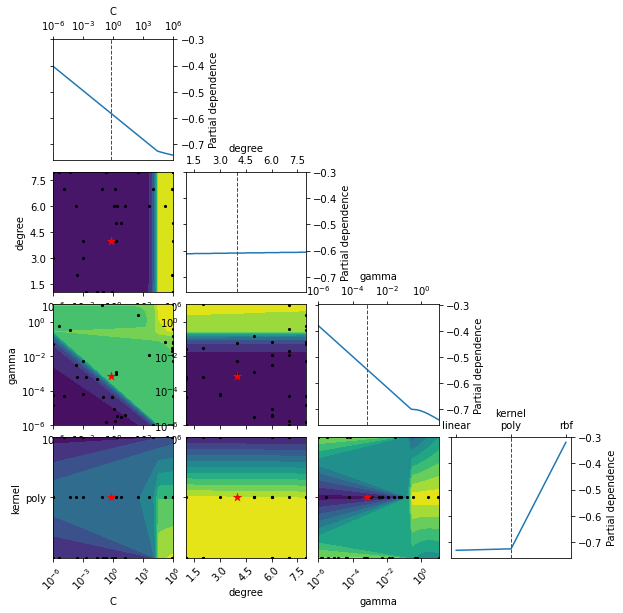

In [36]:
#SVC에 대한 목적 함수의 부분 종속성 플롯
_ = plot_objective(opt.optimizer_results_[0],
                   dimensions=["C", "degree", "gamma", "kernel"],
                   n_minimum_search=int(1e8))
plt.show()

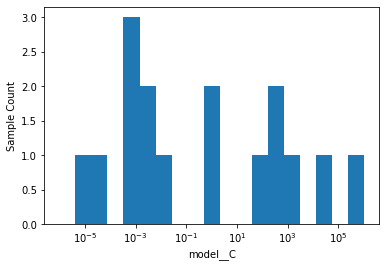

In [37]:
#LinearSVC에 대한 히스토그램 플롯
_ = plot_histogram(opt.optimizer_results_[1], 1)
plt.show()

## Ensemble
개인적으로 앙상블은 머신러닝의 꽃이라고 생각합니다. 단일 모델로 좋은 성능을 이끄는 것도 중요하지만, 서로 다른 모델의 다양성을 고려하여 결과를 이끌어내는 앙상블은 응용할 수 있는 방법이 매우 많습니다. <br>
그 중 대표적인 3가지 앙상블에 대해 실습하고 배워보도록 하겠습니다. 

### 1. Voting Ensemble
이름에서 알 수 있듯이 각자의 모델이 투표를 하여 클래스를 선택하는 방식의 앙상블 입니다. <br>
Voting 앙상블은 Sklearn 자체적으로 모델로써 지원을 하며, 사용하기도 매우 쉽습니다. <br>

다시 Adult 데이터셋으로 돌아와 앙상블을 통해 기존 단일 모델보다 좋은 결과를 얻어보도록 하겠습니다.

Voting Classifier는 Sklearn의 ensemble 패키지에 있습니다.

#### 1) 모델 불러오기 및 정의하기

In [33]:
from sklearn.neural_network import MLPClassifier

In [34]:
from sklearn.ensemble import VotingClassifier
clfs = [('LR', LogisticRegression()), ('RF', RandomForestClassifier(max_depth=5)), ('MLP', MLPClassifier()) ]

vote_clf = VotingClassifier(clfs)

#### 2) 모델 학습하기

In [35]:
vote_clf.fit(x_train, y_train)

VotingClassifier(estimators=[('LR', LogisticRegression()),
                             ('RF', RandomForestClassifier(max_depth=5)),
                             ('MLP', MLPClassifier())])

In [36]:
print('Cross Validation Acc : {:.2f}%'.format(vote_clf.score(x_valid, y_valid)*100))

Cross Validation Acc : 80.67%


#### 3) 결과 예측하기

In [37]:
y_pred = vote_clf.predict(x_test)

#### 4) 결과 확인하기

In [38]:
print('Voting Ensemble Acc : {:.2f}%'.format(vote_clf.score(x_test, y_test)*100))

Voting Ensemble Acc : 80.66%


### 2. Bagging, Average Blending
앙상블 기법 중 캐글에서 가장 많이 사용되는 기법이면서 쉬운 기법입니다. Average Blending에서 회귀의 경우 각 모델들이 예측한 결과 값을 n으로 나누어 합칩니다.<br>
분류의 경우에는 각 클래스에 해당하는 확률을 n으로 나누어 합치고, 그 중 가장 높은 확률 값을 갖는 클래스를 택하는 방식입니다. 

In [39]:
# 단일 모델에서의 Random Forest 성능
clf = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=2019)
clf.fit(x_train, y_train)
print('Single Random Forest Acc : {:.2f}%'.format(clf.score(x_test, y_test)*100))

Single Random Forest Acc : 83.42%


In [40]:
val_scores = list()

y_pred = np.zeros_like(y_test, dtype=np.float)

for i, (trn_idx, val_idx) in enumerate(skf.split(x, y)) :
    trn_data, trn_label = x.values[trn_idx, :], y.values[trn_idx]
    val_data, val_label = x.values[val_idx, :], y.values[val_idx]
    
    # 모델 정의
    clf = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=2019)
    
    # 모델 학습
    clf.fit(trn_data, trn_label)
    trn_acc = clf.score(trn_data, trn_label)*100
    val_acc = clf.score(val_data, val_label)*100
    print('{} Fold, train Accuracy : {:.2f}%, validation Accuracy : {:.2f}%'.format(i, trn_acc, val_acc))
    
    val_scores.append(val_acc)
    y_pred += (clf.predict_proba(x_test)[:, 1] / skf.n_splits)
    
# Mean Validation Score
print('Cross Validation Score : {:.2f}%'.format(np.mean(val_scores)))

0 Fold, train Accuracy : 82.96%, validation Accuracy : 83.63%
1 Fold, train Accuracy : 84.08%, validation Accuracy : 83.94%
2 Fold, train Accuracy : 84.01%, validation Accuracy : 83.48%
3 Fold, train Accuracy : 83.84%, validation Accuracy : 83.27%
4 Fold, train Accuracy : 84.03%, validation Accuracy : 84.13%
Cross Validation Score : 83.69%


In [41]:
# 확률을 이진 라벨로 변경해줍니다.
y_pred = [0 if y < 0.5 else 1 for y in y_pred]
print('Average Blending Acc : {:.2f}%'.format(accuracy_score(y_test, y_pred)*100))

Average Blending Acc : 83.39%


### Reference
- Validation 데이터가 필요한 이유 : https://3months.tistory.com/118
- Sklearn, KFold : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
- Sklearn, StratifedKFold : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold
- Sklearn, Compare with KFold, StratifedKFold : https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
- Sklearn, Cross Validation Score : https://www.google.com/url?q=http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html&sa=U&ved=0ahUKEwiGxeHhqubhAhUKV7wKHbFhDrcQFggEMAA&client=internal-uds-cse&cx=016639176250731907682:tjtqbvtvij0&usg=AOvVaw0rIHEJ1ltDaghFv1bvPeRO
- Sklearn, GridSearchCV : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- Sklearn, Voting Classifier : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
- Scikit-Optimize, Documentation : https://scikit-optimize.github.io 